<a href="https://colab.research.google.com/github/flora0110/podcast_segment_headine/blob/main/podcast_to_headline_history.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [1]:
!pip install word2vec

     |████████████████████████████████| 42 kB 385 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=3815d048621032fc8dde9b7e5a7cf572dc775d00fec92262a59a3091044bfdea
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [2]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [3]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

--2022-04-15 01:02:39--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  2.27MB/s    in 13s     

2022-04-15 01:02:53 (2.27 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  ./text8.zip
  inflating: text8                   


In [4]:
links = {'podcast_text': 'https://raw.githubusercontent.com/flora0110/podcast_segment_headine/main/podcast_data/history_comma.txt'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

--2022-04-15 01:02:55--  https://raw.githubusercontent.com/flora0110/podcast_segment_headine/main/podcast_data/history_comma.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28069 (27K) [text/plain]
Saving to: ‘history_comma.txt’

history_comma.txt   100%[===================>]  27.41K  --.-KB/s    in 0.002s  

2022-04-15 01:02:55 (12.0 MB/s) - ‘history_comma.txt’ saved [28069/28069]



## Train wordvectors

In [5]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [6]:
model.save(wrdvec_path)

In [7]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [8]:
!pip install textsplit

     |████████████████████████████████| 154 kB 5.1 MB/s 


In [9]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [10]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### podcast

In [11]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  25#@param {type:"integer"}

penalty 44.86
489 sentences, 20 segments, avg 24.45 sentences per segment
optimal score 9950.23, greedy score 9932.38
[9950.231709727972, 9932.377336069949]
(9950.231709727972, 9932.377336069949)
ratio of scores 1.0018


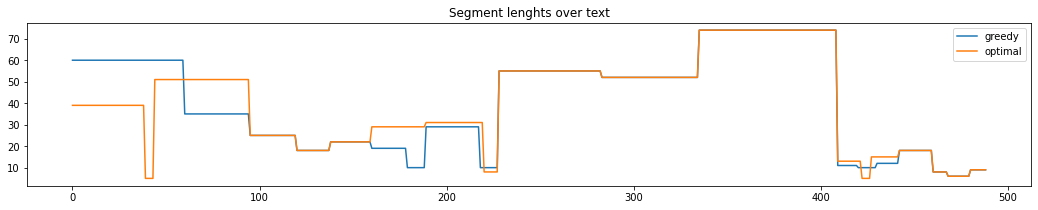

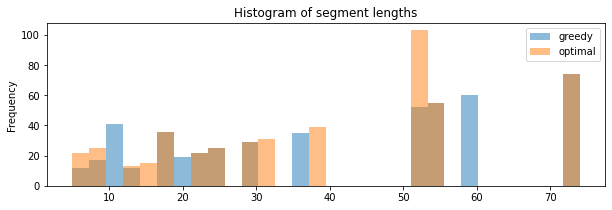

In [12]:
link = links['podcast_text']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [13]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['Hi friends. ', "Happy Wednesday or Thursday if you're watching over on YouTube. ", 'Hey, how are you doing? ', "I hope you're having a wonderful day so far. ", 'My name is Bailey serían and this is the dark History Podcast. ', 'Whew, I need a theme song for dark history. ', "Don't, I'm anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that. ", 'I never learned in school. ', "If you're new here. ", 'Hi, welcome. ', 'Come. ', 'Take a seat by me. ', "Don't be shy if you're And learning about people and events that your history books didn't cover in school. ", "The maybe should have then you'll fit in right in here with us. ", 'Okay. ', "Look today's story. ", "It's uncomfortable. ", "Okay, it's heartbreaking. ", "It's just, it's set. ", "It's awful. ", "It's sad. ", "There's, those are all the words. ", "I can think of it, just doesn't make any sense. ", "But with all of that being said, there's really like no sugarcoating thi

In [14]:
print(sentenced_text)

['Hi friends. ', "Happy Wednesday or Thursday if you're watching over on YouTube. ", 'Hey, how are you doing? ', "I hope you're having a wonderful day so far. ", 'My name is Bailey serían and this is the dark History Podcast. ', 'Whew, I need a theme song for dark history. ', "Don't, I'm anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that. ", 'I never learned in school. ', "If you're new here. ", 'Hi, welcome. ', 'Come. ', 'Take a seat by me. ', "Don't be shy if you're And learning about people and events that your history books didn't cover in school. ", "The maybe should have then you'll fit in right in here with us. ", 'Okay. ', "Look today's story. ", "It's uncomfortable. ", "Okay, it's heartbreaking. ", "It's just, it's set. ", "It's awful. ", "It's sad. ", "There's, those are all the words. ", "I can think of it, just doesn't make any sense. ", "But with all of that being said, there's really like no sugarcoating thi

### 處理輸入

In [15]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [16]:
print(podcast_test)

["Hi friends. Happy Wednesday or Thursday if you're watching over on YouTube. Hey, how are you doing? I hope you're having a wonderful day so far. My name is Bailey serían and this is the dark History Podcast. Whew, I need a theme song for dark history. Don't, I'm anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that. I never learned in school. If you're new here. Hi, welcome. Come. Take a seat by me. Don't be shy if you're And learning about people and events that your history books didn't cover in school. The maybe should have then you'll fit in right in here with us. Okay. Look today's story. It's uncomfortable. Okay, it's heartbreaking. It's just, it's set. It's awful. It's sad. There's, those are all the words. I can think of it, just doesn't make any sense. But with all of that being said, there's really like no sugarcoating this. This is what happened. And it's when more honest and when we're transparent that we can l

# Headline generator

In [17]:
! pip install transformers datasets

     |████████████████████████████████| 4.0 MB 4.9 MB/s 
     |████████████████████████████████| 325 kB 48.1 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 6.6 MB 31.3 MB/s 
     |████████████████████████████████| 895 kB 49.9 MB/s 
     |████████████████████████████████| 596 kB 38.1 MB/s 
     |████████████████████████████████| 212 kB 57.1 MB/s 
     |████████████████████████████████| 1.1 MB 33.6 MB/s 
     |████████████████████████████████| 136 kB 44.8 MB/s 
     |████████████████████████████████| 127 kB 30.6 MB/s 
     |████████████████████████████████| 271 kB 31.9 MB/s 
     |████████████████████████████████| 144 kB 11.3 MB/s 
     |████████████████████████████████| 94 kB 2.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling

In [18]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [19]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [20]:
headlineGenerator = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [21]:
#@title 生成標題的長度 { display-mode: "form" }
min_length =  5#@param {type:"integer"}
max_length = 150#@param {type:"integer"}

In [22]:
headlines = headlineGenerator(podcast_test, min_length, max_length)


Ignoring args : (5, 150)
Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


### 顯示結果

In [23]:
for headline in headlines:
  print(headline)
  print(type(headline))

{'generated_text': 'The Dark History Podcast'}
<class 'dict'>
{'generated_text': 'The Death of James Taylor'}
<class 'dict'>
{'generated_text': 'The Rosewood Massacre'}
<class 'dict'>
{'generated_text': 'Best Fiends - The Mobile Puzzle Game That Will Put A Challenge To Your Nogg'}
<class 'dict'>
{'generated_text': 'Best Fiends - The Best Fiends Game'}
<class 'dict'>
{'generated_text': "What's Going On Screaming?"}
<class 'dict'>
{'generated_text': 'The Black Man Attacked Fanny'}
<class 'dict'>
{'generated_text': "Sarah's Version of the White Man Attacking Fanny"}
<class 'dict'>
{'generated_text': 'Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter'}
<class 'dict'>
{'generated_text': 'The Posse, The Posse, The Posse'}
<class 'dict'>
{'generated_text': "Hello Fresh - America's Number One Meal Kit"}
<class 'dict'>
{'generated_text': 'The Black Community in Rosewood, Texas'}
<class 'dict'>
{'generated_text': 'John, Save His House, But Burn All These Over Here'}
<class 'di

In [24]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Dark History Podcast']
['The Dark History Podcast']
<class 'str'>
['The Death of James Taylor']
['The Death of James Taylor']
<class 'str'>
['The Rosewood Massacre']
['The Rosewood Massacre']
<class 'str'>
['Best Fiends', '-', 'The Mobile Puzzle Game That Will Put A Challenge To Your Nogg']
['Best Fiends', '-', 'The Mobile Puzzle Game That Will Put A Challenge To Your Nogg']
<class 'str'>
['Best Fiends', '-', 'The Best Fiends Game']
['Best Fiends', '-', 'The Best Fiends Game']
<class 'str'>
["What's Going On Screaming?"]
["What's Going On Screaming?"]
<class 'str'>
['The Black Man Attacked Fanny']
['The Black Man Attacked Fanny']
<class 'str'>
["Sarah's Version of the White Man Attacking Fanny"]
["Sarah's Version of the White Man Attacking Fanny"]
<class 'str'>
['Jesse Hunter', ',', 'Jesse Hunter', ',', 'Jesse Hunter', ',', 'Jesse Hunter', ',', 'Jesse Hunter']
['Jesse Hunter', ',', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
<class 'str'>
['The Posse', ',', 'The Posse', ',', 'The Posse']


In [25]:
for headline_string in headlines_string:
  print(headline_string)

 The Dark History Podcast
 The Death of James Taylor
 The Rosewood Massacre
 Best Fiends - The Mobile Puzzle Game That Will Put A Challenge To Your Nogg
 Best Fiends - The Best Fiends Game
 What's Going On Screaming?
 The Black Man Attacked Fanny
 Sarah's Version of the White Man Attacking Fanny
 Jesse Hunter ,
 The Posse ,
 Hello Fresh - America's Number One Meal Kit
 The Black Community in Rosewood , Texas
 John , Save His House But Burn All These Over Here
 Rosewood Massacre - Five of the Rosewood Massacre
 The KKK - What Are They Doing?
 Rosewood , a Black Town in the Middle East
 John and William Bryce , I Know . I Don't Know 
 The Brace Brothers Helped the Rosewood Train Station
 Squarespace - The New City
 Squarespace - The Perfect Platform For Brand Branding


In [26]:
b = "abc, ss dd, www"
a = re.split(r"([,])",b)
print(a)

['abc', ',', ' ss dd', ',', ' www']


# 去掉廣告

In [27]:
!pip install -U scikit-learn
!pip install --user -U nltk

     |████████████████████████████████| 1.5 MB 5.1 MB/s 
     |████████████████████████████████| 749 kB 58.3 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 使用停使用停用詞(NLTK)

In [29]:
# 下面的代碼是使用nltk從句子中去除停用詞 
# 導入包 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download("stopwords")
#set(stopwords.words('english')) 
# 例句 
#text = """He determined to drop his litigation with the monastry, and relinguish his claims to the wood-cuting and fishery rihgts at once. He was the more ready to do this becuase the rights had become much less valuable, and he had indeed the vaguest idea where the wood and river in question were.""" 
# 停用詞集合 
stop_words = set(stopwords.words('english')) 
# 分詞 
nltk.download('punkt')
result_nltk = []
for sent in podcast_test:
  word_tokens = word_tokenize(sent) 
  filtered_sentence = [] 
  for w in word_tokens: 
    if w not in stop_words: 
      filtered_sentence.append(w) 
  result_nltk.append(" ".join(filtered_sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [30]:
print(len(result_nltk))
print(result_nltk)

20
["Hi friends . Happy Wednesday Thursday 're watching YouTube . Hey , ? I hope 're wonderful day far . My name Bailey serían dark History Podcast . Whew , I need theme song dark history . Do n't , I 'm anywho , I 'm talk dark ass history never learned school I , least say . I never learned school . If 're new . Hi , welcome . Come . Take seat . Do n't shy 're And learning people events history books n't cover school . The maybe 'll fit right us . Okay . Look today 's story . It 's uncomfortable . Okay , 's heartbreaking . It 's , 's set . It 's awful . It 's sad . There 's , words . I think , n't make sense . But said , 's really like sugarcoating . This happened . And 's honest 're transparent learn grow together , know , let history repeat . So let 's set scene . It 's New Years Day 1923 many people waking celebrating New Year . Some still wearing flapper dress suit tired dancing . The night away jazz club , maybe 're hung buying illegal drinks speakeasy . Yes . Oh , yes . It still

In [31]:
vectorizer_nltk = CountVectorizer()
transformer_nltk = TfidfTransformer()
tfidf_nltk = transformer_nltk.fit_transform(vectorizer_nltk.fit_transform(result_nltk))
feature_name_nltk = vectorizer_nltk.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
print(len(feature_name_nltk))
print(feature_name_nltk)

1075
['10', '100', '14', '1870s', '1886', '1890', '1900', '1920s', '1923', '1st', '20', '22', '30', '45', '4th', '50', '5th', '9a', 'able', 'absolutely', 'acceptable', 'according', 'accusers', 'across', 'action', 'actually', 'addition', 'adorable', 'adrenaline', 'affair', 'affordable', 'again', 'aggressive', 'agree', 'alcohol', 'alert', 'all', 'alleged', 'alley', 'allow', 'allowed', 'allowing', 'almost', 'alone', 'along', 'also', 'although', 'always', 'america', 'amongst', 'amount', 'and', 'andrews', 'anger', 'angry', 'another', 'answer', 'answers', 'anyone', 'anyway', 'anyways', 'anywho', 'app', 'appealing', 'are', 'areas', 'armed', 'around', 'as', 'ask', 'asked', 'ass', 'assaulted', 'at', 'attack', 'attacked', 'attempt', 'available', 'away', 'awesome', 'awful', 'babe', 'back', 'bad', 'badly', 'bailey', 'barged', 'baseball', 'be', 'beans', 'beat', 'beaten', 'beautiful', 'become', 'becomes', 'before', 'began', 'begin', 'beginning', 'begins', 'behind', 'believe', 'believed', 'believing'

In [33]:
sponsor_n =0
for i in range(len(feature_name_nltk)):
  if feature_name_nltk[i]=='sponsor':
    sponsor_n =i
    print(i)

861


In [34]:
# 找出含sponsor的段落內的keyword和其tfidf
from nltk.util import pr
print(type(tfidf_nltk))
keyword_segment = []
tfidf_segment = []
array_tfidf_nltk = tfidf_nltk.toarray()
for i in range(len(array_tfidf_nltk)):
  if(array_tfidf_nltk[i][sponsor_n]>0):
    print(i)
    for j in range(len(array_tfidf_nltk[i])):
      if(array_tfidf_nltk[i][j]>0):
        keyword_segment.append(feature_name_nltk[j])
        tfidf_segment.append(array_tfidf_nltk[i][j])
        print(feature_name_nltk[j]," ",array_tfidf_nltk[i][j])

<class 'scipy.sparse.csr.csr_matrix'>
3
20   0.06866822105531353
50   0.06866822105531353
addition   0.06866822105531353
almost   0.07811948272489178
also   0.04580540564156934
another   0.10502236502730462
anyone   0.07811948272489178
ask   0.07811948272489178
back   0.04305992084407406
baseball   0.06866822105531353
become   0.06866822105531353
best   0.24784977673292227
black   0.04060400100483066
brain   0.23435844817467533
bruin   0.13733644211062707
but   0.038382351271988725
challenge   0.07811948272489178
churches   0.06866822105531353
close   0.06866822105531353
coexisted   0.07811948272489178
communities   0.07811948272489178
community   0.08611984168814812
currently   0.07811948272489178
end   0.06866822105531353
even   0.038382351271988725
everyone   0.06866822105531353
everything   0.048917979590745966
exercise   0.07811948272489178
feels   0.06866822105531353
felt   0.07811948272489178
fiends   0.27467288422125413
food   0.07811948272489178
fun   0.1858873325496917
game  

In [35]:
print(keyword_segment)
print(tfidf_segment)

['20', '50', 'addition', 'almost', 'also', 'another', 'anyone', 'ask', 'back', 'baseball', 'become', 'best', 'black', 'brain', 'bruin', 'but', 'challenge', 'churches', 'close', 'coexisted', 'communities', 'community', 'currently', 'end', 'even', 'everyone', 'everything', 'exercise', 'feels', 'felt', 'fiends', 'food', 'fun', 'game', 'general', 'get', 'getting', 'go', 'going', 'got', 'great', 'guess', 'have', 'important', 'in', 'it', 'kind', 'know', 'later', 'leave', 'let', 'level', 'like', 'literally', 'looked', 'looking', 'lot', 'majority', 'may', 'mean', 'mill', 'mobile', 'muscle', 'mush', 'my', 'need', 'neighboring', 'nice', 'noggin', 'normal', 'now', 'office', 'one', 'overall', 'pause', 'peaceful', 'people', 'place', 'plus', 'post', 'put', 'puzzle', 'puzzles', 'quarantine', 'rarely', 'really', 'right', 'rosewood', 'schoolhouse', 'seemed', 'sense', 'shifted', 'shit', 'so', 'solve', 'sponsor', 'station', 'stayed', 'store', 'sugar', 'sumner', 'swear', 'team', 'there', 'they', 'thing', 

In [36]:
#@title 設定絕對是sponsor區塊的長度 { display-mode: "form" }
length =  10#@param {type:"integer"}

In [37]:
# 把含sponsor的後lenth句都作為極有可能是sponaor的區塊
sponsor_block = []
for i in range(len(sentenced_text)):
  ws = word_tokenize(sentenced_text[i])
  for w in ws:
    if("sponsor" == w):
      sponsor_block.append(sentenced_text[i])
      for h in range(length):
        if((i+h)<len(sentenced_text)): sponsor_block.append(sentenced_text[i+h])
        
      
sponsor_block = " ".join(sponsor_block)
print(sponsor_block)

They had their own Communities going on and they were just doing their own thing, but unfortunately, that peaceful time was about To end because some shit was a bruin, but before we get into, what was a bruin, let's pause for a word from our sponsor.  They had their own Communities going on and they were just doing their own thing, but unfortunately, that peaceful time was about To end because some shit was a bruin, but before we get into, what was a bruin, let's pause for a word from our sponsor.  Things are kind of getting back to normal, I guess, right?  Yeah, but I swear to you over quarantine.  My brain has felt like mush and need some exercise.  I mean, it is a muscle, right, you know, any who would best fiends.  It feels like my brain.  Got a great workout.  What's best fiends.  You ask?  Well, it's the mobile puzzle game that will put A challenge to your Noggin, and it's kind of like you did a workout.  We're just going to take a little moment here, break for a sponsor that hel

In [54]:
#@title 設定keyword的比例 { display-mode: "form" }
rate =  0.5#@param {type:"number"}

In [57]:
# 把sponsor block內的keyword和tdidf記下來
sponsor_word = word_tokenize(sponsor_block)
print(sponsor_word)

keyword_sponsor=[]
tfidf_sponsor=[]
for i in range(len(sponsor_word)):
  if(sponsor_word[i] in keyword_segment and sponsor_word[i] not in keyword_sponsor):
    keyword_sponsor.append(sponsor_word[i])
    tfidf_sponsor.append(tfidf_segment[keyword_segment.index(sponsor_word[i])])
print(len(keyword_sponsor))
print(len(tfidf_sponsor))
n = len(keyword_sponsor)
for i in range(n):
  for j in range(0,n-i-1):
    
    if(tfidf_sponsor[j]>tfidf_sponsor[j+1]):
      tfidf_sponsor[j], tfidf_sponsor[j+1] =  tfidf_sponsor[j+1], tfidf_sponsor[j]
      keyword_sponsor[j], keyword_sponsor[j+1] =  keyword_sponsor[j+1], keyword_sponsor[j]


key_select = keyword_sponsor[int(rate*len(keyword_sponsor)):len(keyword_sponsor)]
for i in range(0,len(key_select)):
  print(key_select[i]," ",tfidf_sponsor[i+int(rate*len(keyword_sponsor))])

['They', 'had', 'their', 'own', 'Communities', 'going', 'on', 'and', 'they', 'were', 'just', 'doing', 'their', 'own', 'thing', ',', 'but', 'unfortunately', ',', 'that', 'peaceful', 'time', 'was', 'about', 'To', 'end', 'because', 'some', 'shit', 'was', 'a', 'bruin', ',', 'but', 'before', 'we', 'get', 'into', ',', 'what', 'was', 'a', 'bruin', ',', 'let', "'s", 'pause', 'for', 'a', 'word', 'from', 'our', 'sponsor', '.', 'They', 'had', 'their', 'own', 'Communities', 'going', 'on', 'and', 'they', 'were', 'just', 'doing', 'their', 'own', 'thing', ',', 'but', 'unfortunately', ',', 'that', 'peaceful', 'time', 'was', 'about', 'To', 'end', 'because', 'some', 'shit', 'was', 'a', 'bruin', ',', 'but', 'before', 'we', 'get', 'into', ',', 'what', 'was', 'a', 'bruin', ',', 'let', "'s", 'pause', 'for', 'a', 'word', 'from', 'our', 'sponsor', '.', 'Things', 'are', 'kind', 'of', 'getting', 'back', 'to', 'normal', ',', 'I', 'guess', ',', 'right', '?', 'Yeah', ',', 'but', 'I', 'swear', 'to', 'you', 'over', 

## 篩選出名詞和形容詞

In [58]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
def preprocess(sent):
    sent = nltk.pos_tag(sent)
    return sent
part = preprocess(key_select)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [59]:
select_word = []
#part = part.reverse()
for i in range(len(part)):
  if(part[i][1]=='NN' or part[i][1]=='NNS' or part[i][1]=='JJ'or part[i][1]=='JJR'):
    select_word.append(part[i][0])

In [60]:
select_word

['little',
 'end',
 'pause',
 'sponsor',
 'normal',
 'feels',
 'game',
 'everyone',
 'peaceful',
 'shit',
 'quarantine',
 'felt',
 'mush',
 'exercise',
 'muscle',
 'ask',
 'mobile',
 'challenge',
 'meal',
 'cooking',
 'kind',
 'history',
 'right',
 'dark',
 'mean',
 'love',
 'bruin',
 'easy',
 'fun',
 'brain',
 'fiends',
 'fresh']

## 去掉sponsor

In [61]:
for i in range(len(sentenced_text)):
  matches = [a for a in select_word if a in sentenced_text[i]]
  #print(all_sentence[i])
  print(matches)

['end']
[]
[]
[]
['dark']
['history', 'dark']
['history', 'dark']
[]
[]
[]
[]
[]
['history']
['right']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['history']
[]
[]
[]
['easy']
[]
[]
['right']
[]
[]
['little']
['end', 'kind']
['love']
[]
[]
[]
[]
[]
[]
[]
[]
['end']
[]
[]
[]
[]
[]
[]
[]
[]
['history']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['little']
[]
[]
['right']
['history']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['right']
[]
[]
[]
[]
['everyone']
['mean']
['right']
[]
['fun']
[]
[]
[]
['end', 'pause', 'sponsor', 'peaceful', 'shit', 'bruin']
['normal', 'kind', 'right']
['quarantine']
['felt', 'mush', 'exercise', 'brain']
['end', 'muscle', 'right', 'mean', 'fiends']
['feels', 'brain']
[]
['end', 'fiends']
['ask']
['game', 'mobile', 'challenge', 'kind']
['end', 'fun', 'brain', 'fiends']
[]
['end', 'fun']
[]
[]
[]
[]
['end', 'fiends']
['mean']
[]
['little']
['end', 'fiends']
[]
['game']
['end', 'fiends']
['end', 'fiends']
[]
[]
[]
[]
[]
[]
[]
[]
['love']
[]
[]
[]
[]
[]
[]
[]
[]


In [43]:
#@title 設定檢查窗口大小和判定的門檻 { display-mode: "form" }
num =  5#@param {type:"integer"}
match_num=  1#@param {type:"integer"}

In [62]:
before_flag = [0]*num
is_sponsor = []
for i in range(len(sentenced_text)):
  if("sponsor" in sentenced_text[i]):
    
    for j in range(i,len(sentenced_text)):
      matches = [a for a in select_word if a in sentenced_text[j]]
      
      for f in range(num-1,0,-1):
        before_flag[f] = before_flag[f-1]
      if(len(matches)>match_num or i==j): before_flag[0] = 1
      else: before_flag[0] = 0
      print(before_flag)
      flag=0
      for f in range(num):
        if(before_flag[f]==1): 
          flag=1
          break
      if(flag==1):
        if((j-num-1)>=i): is_sponsor.append(sentenced_text[j-num-1])
        
      else:
        is_sponsor.append("----------------------------------------------------------------")
        break
    break

[1, 0, 0, 0, 0]
[1, 1, 0, 0, 0]
[0, 1, 1, 0, 0]
[1, 0, 1, 1, 0]
[1, 1, 0, 1, 1]
[1, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[1, 0, 1, 1, 1]
[0, 1, 0, 1, 1]
[1, 0, 1, 0, 1]
[1, 1, 0, 1, 0]
[0, 1, 1, 0, 1]
[1, 0, 1, 1, 0]
[0, 1, 0, 1, 1]
[0, 0, 1, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 1]
[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 0, 1, 0]
[1, 0, 0, 0, 1]
[0, 1, 0, 0, 0]
[0, 0, 1, 0, 0]
[1, 0, 0, 1, 0]
[1, 1, 0, 0, 1]
[0, 1, 1, 0, 0]
[0, 0, 1, 1, 0]
[0, 0, 0, 1, 1]
[0, 0, 0, 0, 1]
[0, 0, 0, 0, 0]


In [63]:
for sent in is_sponsor: 
  print(sent)

They had their own Communities going on and they were just doing their own thing, but unfortunately, that peaceful time was about To end because some shit was a bruin, but before we get into, what was a bruin, let's pause for a word from our sponsor. 
Things are kind of getting back to normal, I guess, right? 
Yeah, but I swear to you over quarantine. 
My brain has felt like mush and need some exercise. 
I mean, it is a muscle, right, you know, any who would best fiends. 
It feels like my brain. 
Got a great workout. 
What's best fiends. 
You ask? 
Well, it's the mobile puzzle game that will put A challenge to your Noggin, and it's kind of like you did a workout. 
But again, for your brain, not only that, best fiends is so fun. 
You won't want to put it down + best. 
Fiends has literally thousands of fun, puzzles to solve. 
I'm currently on level 50 with like a lot more to go. 
So, there's really nothing to brag about their. 
There's literally something new to play every day. 
And the 

In [65]:
del_sponsor_sentence = []
for i in range(len(sentenced_text)):
  if (sentenced_text[i] not in is_sponsor):
    del_sponsor_sentence.append(sentenced_text[i])
for sent in del_sponsor_sentence: 
  print(sent)

Hi friends. 
Happy Wednesday or Thursday if you're watching over on YouTube. 
Hey, how are you doing? 
I hope you're having a wonderful day so far. 
My name is Bailey serían and this is the dark History Podcast. 
Whew, I need a theme song for dark history. 
Don't, I'm anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that. 
I never learned in school. 
If you're new here. 
Hi, welcome. 
Come. 
Take a seat by me. 
Don't be shy if you're And learning about people and events that your history books didn't cover in school. 
The maybe should have then you'll fit in right in here with us. 
Okay. 
Look today's story. 
It's uncomfortable. 
Okay, it's heartbreaking. 
It's just, it's set. 
It's awful. 
It's sad. 
There's, those are all the words. 
I can think of it, just doesn't make any sense. 
But with all of that being said, there's really like no sugarcoating this. 
This is what happened. 
And it's when more honest and when we're tr

# 重新來分段一次

penalty 42.60
465 sentences, 23 segments, avg 20.22 sentences per segment
optimal score 9519.43, greedy score 9502.85
[9519.434426080186, 9502.848949718209]
(9519.434426080186, 9502.848949718209)
ratio of scores 1.0017


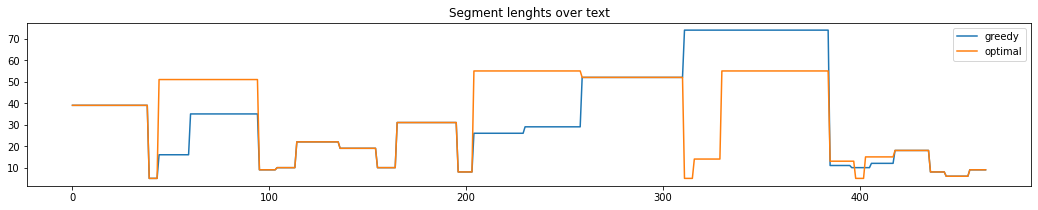

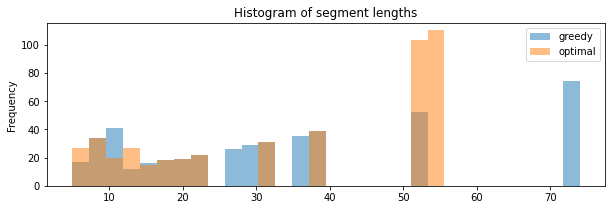

In [66]:
strs = " "
for i in range(len(del_sponsor_sentence)):
  if(del_sponsor_sentence[i] != " "):
    strs =del_sponsor_sentence[i]
  if(i+1<len(del_sponsor_sentence)):
    if(strs == del_sponsor_sentence[i+1]):
      del_sponsor_sentence[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(del_sponsor_sentence).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(del_sponsor_sentence, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(del_sponsor_sentence), len(segmented_text), len(del_sponsor_sentence) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(del_sponsor_sentence, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

In [67]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['Hi friends. ', "Happy Wednesday or Thursday if you're watching over on YouTube. ", 'Hey, how are you doing? ', "I hope you're having a wonderful day so far. ", 'My name is Bailey serían and this is the dark History Podcast. ', 'Whew, I need a theme song for dark history. ', "Don't, I'm anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that. ", 'I never learned in school. ', "If you're new here. ", 'Hi, welcome. ', 'Come. ', 'Take a seat by me. ', "Don't be shy if you're And learning about people and events that your history books didn't cover in school. ", "The maybe should have then you'll fit in right in here with us. ", 'Okay. ', "Look today's story. ", "It's uncomfortable. ", "Okay, it's heartbreaking. ", "It's just, it's set. ", "It's awful. ", "It's sad. ", "There's, those are all the words. ", "I can think of it, just doesn't make any sense. ", "But with all of that being said, there's really like no sugarcoating thi

In [68]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [69]:
headlines = headlineGenerator(podcast_test, min_length, max_length)

Ignoring args : (5, 150)


In [70]:
for headline in headlines:
  print(headline)
  

{'generated_text': 'The Dark History Podcast'}
{'generated_text': 'The Death of James Taylor'}
{'generated_text': 'The Rosewood Massacre'}
{'generated_text': 'Rosewood, a Black Community'}
{'generated_text': 'Best Fiends Free Today on the App Store Or Google Play'}
{'generated_text': "What's Going On Screaming?"}
{'generated_text': 'The Black Man Attacked Fanny'}
{'generated_text': 'Fanny Story - Wait a Minute. Wait a Minute.'}
{'generated_text': "Sarah's Version of the White Man Attacking Fanny"}
{'generated_text': 'Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter'}
{'generated_text': 'The Posse, The Posse, The Posse'}
{'generated_text': "Hello Fresh - America's Number One Meal Kit"}
{'generated_text': 'Rosewood Black Community - A Speculation of a Black Community'}
{'generated_text': 'Sylvester Carriers - The L Story, Sarah'}
{'generated_text': 'The Black Community in Rosewood, Texas'}
{'generated_text': 'John, Save His House, But Burn All These Over Here'}
{'gene

In [71]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Dark History Podcast']
['The Dark History Podcast']
<class 'str'>
['The Death of James Taylor']
['The Death of James Taylor']
<class 'str'>
['The Rosewood Massacre']
['The Rosewood Massacre']
<class 'str'>
['Rosewood', ',', 'a Black Community']
['Rosewood', ',', 'a Black Community']
<class 'str'>
['Best Fiends Free Today on the App Store Or Google Play']
['Best Fiends Free Today on the App Store Or Google Play']
<class 'str'>
["What's Going On Screaming?"]
["What's Going On Screaming?"]
<class 'str'>
['The Black Man Attacked Fanny']
['The Black Man Attacked Fanny']
<class 'str'>
['Fanny Story', '-', 'Wait a Minute', '.', 'Wait a Minute', '.', '']
['Fanny Story', '-', 'Wait a Minute', '.', ' ', ' ', '']
<class 'str'>
["Sarah's Version of the White Man Attacking Fanny"]
["Sarah's Version of the White Man Attacking Fanny"]
<class 'str'>
['Jesse Hunter', ',', 'Jesse Hunter', ',', 'Jesse Hunter', ',', 'Jesse Hunter', ',', 'Jesse Hunter']
['Jesse Hunter', ',', ' ', ' ', ' ', ' ', ' ', 

In [72]:
for headline_string in headlines_string:
  print(headline_string)

 The Dark History Podcast
 The Death of James Taylor
 The Rosewood Massacre
 Rosewood , a Black Community
 Best Fiends Free Today on the App Store Or Google Play
 What's Going On Screaming?
 The Black Man Attacked Fanny
 Fanny Story - Wait a Minute . 
 Sarah's Version of the White Man Attacking Fanny
 Jesse Hunter ,
 The Posse ,
 Hello Fresh - America's Number One Meal Kit
 Rosewood Black Community - A Speculation of a Black Community
 Sylvester Carriers - The L Story , Sarah
 The Black Community in Rosewood , Texas
 John , Save His House But Burn All These Over Here
 Rosewood Massacre - Five of the Rosewood Massacre
 The KKK - What Are They Doing?
 Rosewood , a Black Town in the Middle East
 John and William Bryce , I Know . I Don't Know 
 The Brace Brothers Helped the Rosewood Train Station
 Squarespace - The New City
 Squarespace - The Perfect Platform For Brand Branding
